# COMP 5214 Project

## Settings

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
! pip install tqdm

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device {device}...')

Using device cuda...


In [ ]:
data_dir = './data'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Models


### LeNet-5

In [ ]:
def LeNet5_create_model(num_class):
  return nn.Sequential(
    nn.Conv2d(1, 6, 5, padding = 2), # padding to match the dimensions
    nn.Sigmoid(),
    nn.AvgPool2d(2),

    nn.Conv2d(6, 16, 5),
    nn.Sigmoid(),
    nn.AvgPool2d(2),

    nn.Flatten(),

    nn.Linear(5 * 5 * 16, 120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.Sigmoid(),
    nn.Linear(84, num_class)
  )

### VGG16

In [ ]:
def VGG16_create_model(num_class, mean, std):
  return nn.Sequential(
    torchvision.models.vgg16_bn().features, 
    nn.Flatten(),
    nn.Dropout(p = 0.5),
    nn.Linear(512, num_class)
  ).to(device)

### ResNet18

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18_create_model(num_class, mean, std):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_class).to(device)

## Datasets

### MNIST

In [ ]:
### MNIST
MNIST_training_set = torchvision.datasets.MNIST('./data', train= True, download= True, transform= torchvision.transforms.ToTensor())
MNIST_testing_set = torchvision.datasets.MNIST('./data', train= False, download= True, transform= torchvision.transforms.ToTensor())
MNIST_num_class = 10

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### CIFAR-10

In [ ]:
### CIFAR10
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transform_test = transforms.ToTensor()

CIFAR10_training_set = torchvision.datasets.CIFAR10(root = f'./data', train = True, transform = transform_train, download = True)
CIFAR10_testing_set = torchvision.datasets.CIFAR10(root = f'./data', train = False, transform = transform_test, download = True)
CIFAR10_num_class = 10
CIFAR10_mean, CIFAR10_std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### GTSRB

In [ ]:
### GTSRB
import csv
import pathlib
from typing import Any, Callable, Optional, Tuple

import PIL

from torchvision.datasets.folder import make_dataset
from torchvision.datasets.utils import download_and_extract_archive, verify_str_arg
from torchvision.datasets.vision import VisionDataset

transform_train = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
	  transforms.Resize((32, 32)),
    transforms.ToTensor()
])


class GTSRB(VisionDataset):
    """`German Traffic Sign Recognition Benchmark (GTSRB) <https://benchmark.ini.rub.de/>`_ Dataset.

    Args:
        root (string): Root directory of the dataset.
        split (string, optional): The dataset split, supports ``"train"`` (default), or ``"test"``.
        transform (callable, optional): A function/transform that  takes in an PIL image and returns a transformed
            version. E.g, ``transforms.RandomCrop``.
        target_transform (callable, optional): A function/transform that takes in the target and transforms it.
        download (bool, optional): If True, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
    """

    def __init__(
        self,
        root: str,
        split: str = "train",
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        download: bool = False,
    ) -> None:

        super().__init__(root, transform=transform, target_transform=target_transform)

        self._split = verify_str_arg(split, "split", ("train", "test"))
        self._base_folder = pathlib.Path(root) / "gtsrb"
        self._target_folder = (
            self._base_folder / "GTSRB" / ("Training" if self._split == "train" else "Final_Test/Images")
        )

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError("Dataset not found. You can use download=True to download it")

        if self._split == "train":
            samples = make_dataset(str(self._target_folder), extensions=(".ppm",))
        else:
            with open(self._base_folder / "GT-final_test.csv") as csv_file:
                samples = [
                    (str(self._target_folder / row["Filename"]), int(row["ClassId"]))
                    for row in csv.DictReader(csv_file, delimiter=";", skipinitialspace=True)
                ]

        self._samples = samples
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self) -> int:
        return len(self._samples)


    def __getitem__(self, index: int) -> Tuple[Any, Any]:

        path, target = self._samples[index]
        sample = PIL.Image.open(path).convert("RGB")

        if self.transform is not None:
            sample = self.transform(sample)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target


    def _check_exists(self) -> bool:
        return self._target_folder.is_dir()

    def download(self) -> None:
        if self._check_exists():
            return

        base_url = "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/"

        if self._split == "train":
            download_and_extract_archive(
                f"{base_url}GTSRB-Training_fixed.zip",
                download_root=str(self._base_folder),
                md5="513f3c79a4c5141765e10e952eaa2478",
            )
        else:
            download_and_extract_archive(
                f"{base_url}GTSRB_Final_Test_Images.zip",
                download_root=str(self._base_folder),
                md5="c7e4e6327067d32654124b0fe9e82185",
            )
            download_and_extract_archive(
                f"{base_url}GTSRB_Final_Test_GT.zip",
                download_root=str(self._base_folder),
                md5="fe31e9c9270bbcd7b84b7f21a9d9d9e5",
            )

GTSRB_training_set = GTSRB(root = f'./data', split = 'train', transform = transform_train, download = True)
GTSRB_testing_set = GTSRB(root = f'./data', split = 'test', transform = transform_test, download = True)
GTSRB_num_class = 43
GTSRB_mean, GTSRB_std = (0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629)

  0%|          | 0/187490228 [00:00<?, ?it/s]

Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb


  0%|          | 0/88978620 [00:00<?, ?it/s]

Extracting data/gtsrb/GTSRB_Final_Test_Images.zip to data/gtsrb


  0%|          | 0/99620 [00:00<?, ?it/s]

Extracting data/gtsrb/GTSRB_Final_Test_GT.zip to data/gtsrb


## Settings

### Choose one of the models

In [ ]:
model_name = 'LeNet5'

In [ ]:
model_name = 'VGG16'

In [ ]:
model_name = 'ResNet18'

### Choose one of the datasets

In [ ]:
dataset_name = 'MNIST'

In [ ]:
dataset_name = 'CIFAR10'

In [ ]:
dataset_name = 'GTSRB'

### Get everything ready

In [ ]:
create_model = eval(f'{model_name}_create_model')
training_set, testing_set = eval(f'{dataset_name}_training_set'), eval(f'{dataset_name}_testing_set')
num_class = eval(f'{dataset_name}_num_class')
try: 
  mean, std = eval(f'{dataset_name}_mean'), eval(f'{dataset_name}_std')
except:
  pass

In [ ]:
try:
  model = nn.Sequential(transforms.Normalize(mean, std), create_model(num_class, mean, std)).to(device)
  model[1].load_state_dict(torch.load(f'drive/MyDrive/comp5214-models/{model_name}-{dataset_name}'))
except:
  model = create_model(num_class).to(device)
  model.load_state_dict(torch.load(f'drive/MyDrive/comp5214-models/{model_name}-{dataset_name}'))


In [ ]:
# the accucacy of the base model
testing_loader = torch.utils.data.DataLoader(testing_set, batch_size=128, num_workers = 2)
correct = 0
model.eval()
for X, y in testing_loader:
  probs = model(X.to(device))
  _, pred = probs.max(axis = -1)
  correct += (pred == y.to(device)).sum().item()
print(f'Base model, accuracy = {correct / len(testing_set):.4f}')

Base model, accuracy = 0.9867


## Smoothing

In [ ]:
import torch
from scipy.stats import norm, binom_test
import numpy as np
from math import ceil
from statsmodels.stats.proportion import proportion_confint

from torch.fft import ifft2

class Smooth(object):
  """A smoothed classifier g """

  # to abstain, Smooth returns this int
  ABSTAIN = -1

  def __init__(self, base_classifier: torch.nn.Module, num_classes: int, sigma: float):
    """
    :param base_classifier: maps from [batch x channel x height x width] to [batch x num_classes]
    :param num_classes:
    :param sigma: the noise level hyperparameter
    """
    self.base_classifier = base_classifier
    self.num_classes = num_classes
    self.sigma = sigma

  def radius_lower_bound(self, NA: int, N: int, alpha: float) -> float:
    """ Returns a (1 - alpha) lower confidence bound on a bernoulli proportion.

    This function uses the Clopper-Pearson method.

    :param NA: the number of "successes"
    :param N: the number of total draws
    :param alpha: the confidence level
    :return: a lower bound on the binomial proportion which holds true w.p at least (1 - alpha) over the samples
    """
    pABar = proportion_confint(NA, N, alpha=2 * alpha, method="beta")[0]
    if pABar < 0.5:
      return np.nan
    else:
      radius = self.sigma * norm.ppf(pABar)
      return radius

  def certify(self, X: torch.tensor, num_sample_selection: int, num_sample_estimation: int, alpha: float):
    """ Monte Carlo algorithm for certifying that g's prediction around x is constant within some L2 radius.
    With probability at least 1 - alpha, the class returned by this method will equal g(x), and g's prediction will
    robust within a L2 ball of radius R around x.

    :param X: the input (N, C, H, W)
    :param n0: the number of Monte Carlo samples to use for selection
    :param n: the number of Monte Carlo samples to use for estimation
    :param alpha: the failure probability
    :param batch_size: batch size to use when evaluating the base classifier
    """
    N, C, H, W = X.shape
    self.base_classifier.eval()
    # draw samples of f(x+ epsilon)
    counts_selection = self.sample_noise(X, num_sample_selection)
    # use these samples to take a guess at the top class
    cAHat = torch.argmax(counts_selection, axis = -1)
    # draw more samples of f(x + epsilon)
    counts_estimation = self.sample_noise(X, num_sample_estimation)
    # use these samples to estimate a lower bound on pA
    nA = counts_estimation[torch.arange(N, device = device), cAHat].cpu().numpy()

    radius = np.vectorize(lambda z: self.radius_lower_bound(z, num_sample_estimation, alpha))(nA)
    mask = ~np.isnan(nA)

    pred = cAHat.cpu().numpy()
    pred[~mask] = Smooth.ABSTAIN

    return pred, radius


  def predict(self, X: torch.tensor, num_sample: int, alpha: float):
    """ Monte Carlo algorithm for evaluating the prediction of g at x.  With probability at least 1 - alpha, the
    class returned by this method will equal g(x).

    This function uses the hypothesis test described in https://arxiv.org/abs/1610.03944
    for identifying the top category of a multinomial distribution.

    :param x: the input (N, C, H, W)
    :param num_sample: the number of Monte Carlo samples to use
    :param alpha: the failure probability
    :return: the predicted class, or ABSTAIN
    """
    self.base_classifier.eval()
    counts = self.sample_noise(X, num_sample)
    counts_sorted, indices = torch.sort(counts, descending = True)

    p_values = np.vectorize(binom_test)(counts_sorted[:, 0].cpu().numpy(), counts_sorted[:, 0].cpu().numpy() + counts_sorted[:, 1].cpu().numpy())
    abstain_mask = p_values > alpha
    
    out = indices[:, 0].cpu().numpy()
    out[abstain_mask] = Smooth.ABSTAIN

    return out

  def sample_noise(self, X: torch.tensor, num_sample: int):
    """ Sample the base classifier's prediction under noisy corruptions of the input x.

    :param x: the input [channel x width x height]
    :param num: number of samples to collect
    :return: an ndarray[int] of length num_classes containing the per-class counts
    """
    assert not self.base_classifier.training
    with torch.no_grad():
      N, C, H, W = X.shape 
      fourier_domain_noise = torch.view_as_complex(torch.normal(mean = 0.0, std = self.sigma / np.sqrt(2), size = (N, num_sample, C, H, W, 2), device = device))
      pixel_domain_noise = torch.real(ifft2(fourier_domain_noise))
      samples = X.to(device)[:, None, ...] + pixel_domain_noise

      logits = self.base_classifier(samples.view(-1, *samples.shape[-3:])).view(*samples.shape[:-3], -1)
      pred = logits.argmax(axis = -1)
      counts = F.one_hot(pred, num_classes = self.num_classes).sum(axis = -2)

      return counts

  

## Results

### Robustness-accuracy tradeoff 

In [ ]:
from tqdm import tqdm
testing_loader =torch.utils.data.DataLoader(testing_set, batch_size=16, num_workers= 2)
sigmas = [1, 2, 4, 8]
accuracies = []

with torch.no_grad():
  for s in sigmas:
    correct = 0
    G = Smooth(model, num_class, sigma = s)
    for X, y in tqdm(testing_loader):
      pred = G.predict(X, 100, 0.05)
      correct += (pred == y.numpy()).sum()
    accuracies.append(correct / len(testing_set))
    print(f'Sigma = {s}, accuracy = {accuracies[-1]}.')



  2%|▏         | 10/625 [00:03<03:44,  2.74it/s]


KeyboardInterrupt: ignored

|TASK|Baseline|1|2|4|8|16|32|64|
|--------|------|------|------|------|------|------|------|------|
|L-MNIST |98.67 |98.65 |98.66 |98.59 |98.21 |94.68|63.61|27.2|
|R-GTSRB |90.70 |87.29 |70.67 |22.56 |10.8| | | |
|V-GTSRB |91.97 |85.70 |64.47 |20.00 |10.37| | | |
|V-GTSRB |97.60 |96.99 |94.43 |82.09 |60.86| 28.91 | | |
|R-GTSRB |98.50 |97.72 |92.14 |75.20 |52.34|16.62 | | |




In [ ]:
sigmas = [2, 8, 32]
certified_radii_array = []
benchmark_radius = [0, 1, 2, 4, 8, 16, 32, 64]

100%|██████████| 157/157 [00:28<00:00,  5.50it/s]


Sigma = 2, accuracy = 0.9867


100%|██████████| 157/157 [00:28<00:00,  5.52it/s]


Sigma = 8, accuracy = 0.9841


100%|██████████| 157/157 [00:28<00:00,  5.50it/s]


Sigma = 32, accuracy = 0.6703


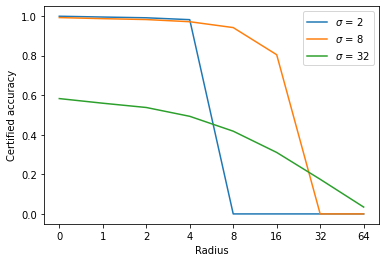

In [ ]:
# radii contains certified radius
import matplotlib.pyplot as plt
from tqdm import tqdm

for s in sigmas:
  testing_loader = torch.utils.data.DataLoader(testing_set, batch_size=64, num_workers = 2)
  G = Smooth(model, num_class, sigma = s)
  correct, radii = 0, []
  for X, y in tqdm(testing_loader):
    #pred = G.predict(X, 1000, 0.5)
    pred, radius = G.certify(X, 1000, 1000, 0.05)
    correct += (pred == y.numpy()).sum()
    radii.append(radius)
  radii = np.concatenate(radii)
  print(f'Sigma = {s}, accuracy = {correct/len(testing_set):.4f}')

  plt.plot([(radii >= br).mean() for br in benchmark_radius], label = '$\sigma$ = '+f'{s}')

plt.xlabel('Radius')
plt.ylabel('Certified accuracy')
plt.xticks(np.arange(len(benchmark_radius)), benchmark_radius)

  

plt.legend()
plt.savefig(f'{model_name}-{dataset_name}-tradeoff.png')